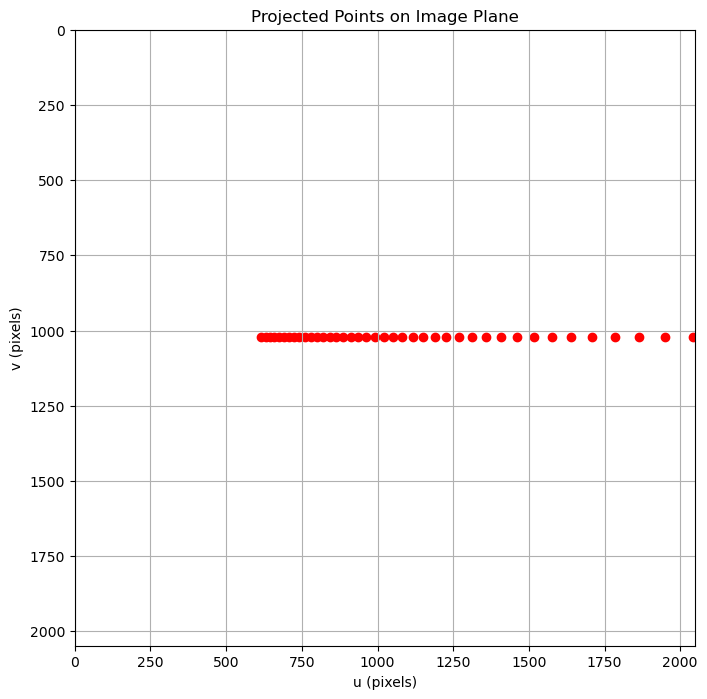

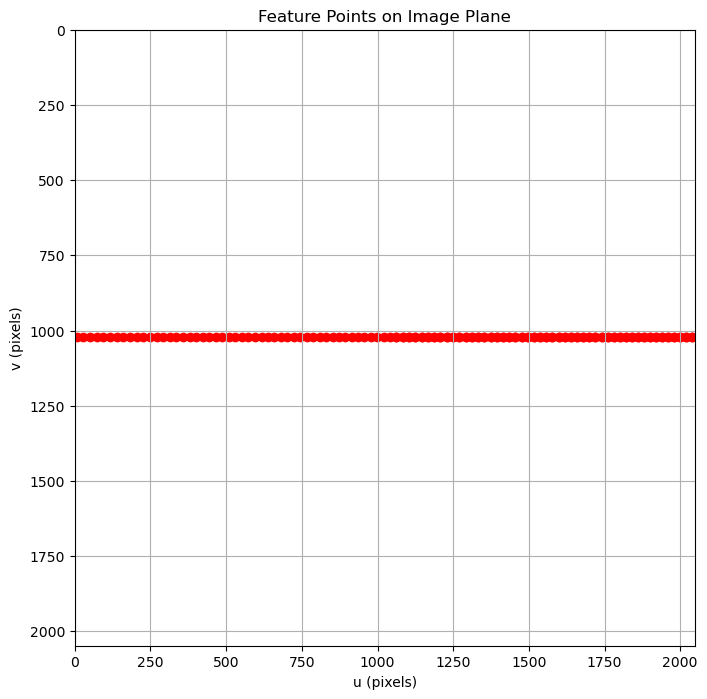

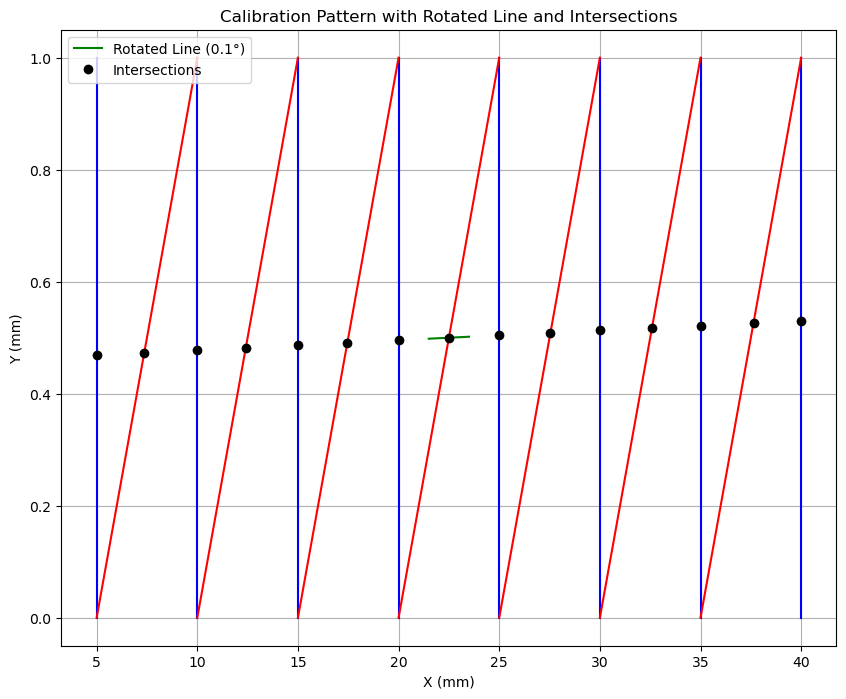

Sorted Intersection Points:
(5.00, 0.47)
(7.37, 0.47)
(10.00, 0.48)
(12.41, 0.48)
(15.00, 0.49)
(17.46, 0.49)
(20.00, 0.50)
(22.50, 0.50)
(25.00, 0.50)
(27.54, 0.51)
(30.00, 0.51)
(32.59, 0.52)
(35.00, 0.52)
(37.63, 0.53)
(40.00, 0.53)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Calibration pattern parameters
num_vertical_lines = 8  # Number of vertical lines (P_i)
num_slanted_lines = num_vertical_lines - 1  # Number of slanted lines (D_i)
line_length = 1  # Length of the lines in mm
line_spacing = 5   # Spacing between vertical lines (h) in mm

# Generate vertical lines (P_i)
vertical_lines = []
for i in range(1, num_vertical_lines + 1):
    x = i * line_spacing
    y_start = 0
    y_end = line_length
    vertical_lines.append(((x, y_start), (x, y_end)))

# Generate slanted lines (D_i)
slanted_lines = []
for i in range(1, num_slanted_lines + 1):
    x_start = i * line_spacing
    x_end = (i + 1) * line_spacing
    y_start = 0
    y_end = line_length
    slanted_lines.append(((x_start, y_start), (x_end, y_end)))

# Define the rotated line
theta_deg = 0.1  # Angle in degrees (you can change this to rotate the line)
theta_rad = np.radians(theta_deg)

# Compute center of the pattern
x_center = ((1 + num_vertical_lines) / 2) * line_spacing
y_center = line_length / 2

L_large = line_length * 2  # Length of the rotated line

x0 = x_center - (L_large / 2) * np.cos(theta_rad)
y0 = y_center - (L_large / 2) * np.sin(theta_rad)
x1 = x_center + (L_large / 2) * np.cos(theta_rad)
y1 = y_center + (L_large / 2) * np.sin(theta_rad)

rotated_line = ((x0, y0), (x1, y1))

# Function to compute intersection
def line_intersection(line1, line2):
    """Find the intersection point of two lines given as pairs of points.
       Each line is defined by ((x1, y1), (x2, y2))
       Returns (x, y) if the lines intersect, or None if they are parallel."""
    x1, y1 = line1[0]
    x2, y2 = line1[1]
    x3, y3 = line2[0]
    x4, y4 = line2[1]
    
    # Compute the denominator
    denominator = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
    if abs(denominator) < 1e-10:
        # Lines are parallel
        return None
    else:
        # Compute the intersection point
        numerator_px = (x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)
        numerator_py = (x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)
        px = numerator_px / denominator
        py = numerator_py / denominator
        return (px, py)

# Find intersection points
intersection_points = []

# Intersections with vertical lines
for line in vertical_lines:
    intersection = line_intersection(rotated_line, line)
    if intersection is not None:
        intersection_points.append(intersection)

# Intersections with slanted lines
for line in slanted_lines:
    intersection = line_intersection(rotated_line, line)
    if intersection is not None:
        intersection_points.append(intersection)

# Sort the intersection points by x-coordinate (primary) and y-coordinate (secondary)
intersection_points_sorted = sorted(intersection_points, key=lambda point: (point[0], point[1]))

# Plot the calibration pattern
plt.figure(figsize=(10, 8))
for line in vertical_lines:
    plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'b-')
for line in slanted_lines:
    plt.plot([line[0][0], line[1][0]], [line[0][1], line[1][1]], 'r-')

# Plot the rotated line
plt.plot([x0, x1], [y0, y1], 'g-', label=f'Rotated Line ({theta_deg}°)')

# Plot the intersection points
intersection_xs = [pt[0] for pt in intersection_points_sorted]
intersection_ys = [pt[1] for pt in intersection_points_sorted]
plt.plot(intersection_xs, intersection_ys, 'ko', label='Intersections')

plt.title('Calibration Pattern with Rotated Line and Intersections')
plt.xlabel('X (mm)')
plt.ylabel('Y (mm)')
plt.legend()
plt.grid(True)
plt.show()

# Print the sorted intersection points
print("Sorted Intersection Points:")
for pt in intersection_points_sorted:
    print(f"({pt[0]:.2f}, {pt[1]:.2f})")


(15,)
(15, 2)


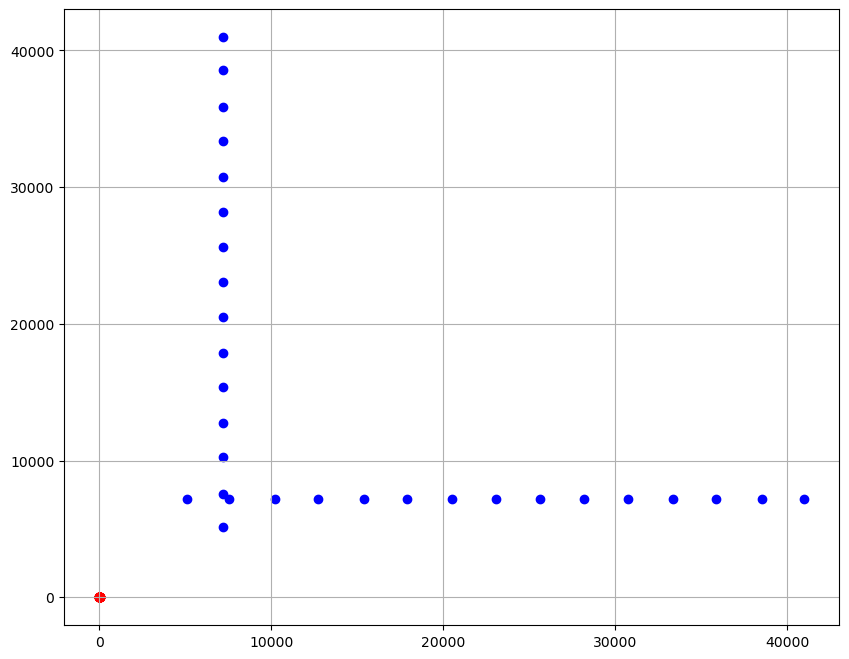

In [8]:
# Step 2 feature point correspondences

def cross_ratio(unit):
    if unit.size != 4 or unit.ndim != 1:
        raise ValueError("Input must be a 1D numpy array with exactly four elements.")
    
    A, B, C, D = unit
    return ((C-A) / (C-B)) / ((D-A) / (D-B))


def feature_points_correspondences(X_image_coordinates, h, l):
    # P D P D P D P

    # Pad last vertical line based on ca = da * 2
    ca_last = X_image_coordinates[-1] - X_image_coordinates[-3]
    X_image_coordinates = np.append(X_image_coordinates, [0, X_image_coordinates[-1] + ca_last])
    
    #Find all diagonal X in pattern coordinates
    i = 1
    diagonal = []
    for i_cross in range(0, len(X_image_coordinates) - 4, 2):  # Move 2 steps forward each iteration
        # Find ABCD according to figure 2 in paper
        ABCD = X_image_coordinates[[i_cross, i_cross+1, i_cross+2, i_cross+4]] # A B C D
        # Cross ratio
        r_abcd = cross_ratio(ABCD)
        eta = (2*r_abcd-2) / (2*r_abcd-1)
        # Find X
        x_b = eta * h + (i-1)*h
        # Find Y
        y_b = (l/h) * x_b - (i - 1) * l
        # Next diagonal line
        i = i + 1
        #append
        diagonal.append([x_b, y_b])

    #Find all other lines
    diagonal = np.array(diagonal) 
    vertical = []
    for i in range(0, len(diagonal), 2):
        x_a = i*h
        if i != 0:
            x_c = (i+1)*h
        else:
            x_c = 1*h

        # Extract coordinates from diagonals
        if i != len(diagonal)-1:
            dia_points = diagonal[[i,i+1]]
        else:
            dia_points = diagonal[[i-1, i]]

        x1, y1 = dia_points[0]
        x2, y2 = dia_points[1]
        # Calculate slope (m)
        m = (y2 - y1) / (x2 - x1)
        # Calculate y-intercept (b)
        b = y1 - m * x1
        # Calculate y
        y_a = m * x_a + b
        y_c = m * x_c + b
        # append
        vertical.append([x_a,y_a])
        vertical.append([x_c, y_c])

    vertical = np.array(vertical)
    # Create an empty array for interlaced coordinates
    pattern_coordinates = np.empty((diagonal.shape[0] + vertical.shape[0], 2), dtype=diagonal.dtype)

    # Interlace arrays
    pattern_coordinates[0::2] = vertical  # Place `vertical` elements at even rows
    pattern_coordinates[1::2] = diagonal  # Place `diagonal` elements at odd rows
    return pattern_coordinates

def project_feature_points_1d_to_2d(points_1d, u):
    """
    Projects 1D feature points onto a 2D space by rotating 90 degrees around an estimated optical center.
    ASSUMING FIRST PART OF ARRAY IS POINTS AND NEXT PART IS PROJECTION
    """
    # Start by finding points
    Y = np.ones(np.size(X_image_coordinates)) * u
    points_2d = np.vstack((points_1d, Y)).T

    # Find projection
    rotation_matrix = np.array([[0, -1], [1, 0]])
    points_2d_projection = []

    for point in points_1d:
        # Map 1D points to 2D by duplicating the contrast
        point_2d_projection = rotation_matrix @ (np.array([point, u]) - np.array([u, u])) + np.array([u, u])
        points_2d_projection.append(point_2d_projection)
    
    return np.vstack((points_2d,points_2d_projection))

def find_optical_pattern(image_coords, pattern_coords, u):
    low_index = np.searchsorted(image_coords,u)

    Pattern_low = pattern_coords[low_index-1]
    Pattern_high = pattern_coords[low_index]

    dist_u_image = u - image_coords[low_index-1]
    dist_image = image_coords[low_index] - image_coords[low_index-1]
    dist_pattern = Pattern_high[0] - Pattern_low[0]

    Pattern_to_Image = dist_pattern/dist_image
    dist_u_pattern = Pattern_to_Image * dist_u_image

    x_a = Pattern_low[0]+dist_u_pattern
    x1, y1 = Pattern_low
    x2, y2 = Pattern_high
    # Calculate slope (m)
    m = (y2 - y1) / (x2 - x1)
    # Calculate y-intercept (b)
    b = y1 - m * x1
    # Calculate y
    y_a = m * x_a + b

    return np.array([x_a,y_a])

def project_pattern_points(image_coords, pattern_coords, optical_center):
    #find optical pattern
    pattern_optical = find_optical_pattern(image_coords, pattern_coords, optical_center)
    
    #rotate
    rotation_matrix = np.array([
        [0, -1],
        [1, 0]
    ])

    translated_points = pattern_coords - pattern_optical
    rotated_translated_points = translated_points @ rotation_matrix.T
    rotated_pattern_coords = rotated_translated_points + pattern_optical

    return np.vstack((pattern_coords,rotated_pattern_coords))

def calibration(X_pixels_points, hight_pattern, length_pattern):
    #Step 1 find pattern coordinate space:

    #Step 2 Find image coordinate space in 2D:

    #Step 3 Find optical center
    return 0
    


scale = 1024

X_image_coordinates = [x*scale for x, _ in intersection_points_sorted]
pattern_coordinates = feature_points_correspondences(np.array(X_image_coordinates),5,1)
print(np.array(X_image_coordinates).shape)
print(pattern_coordinates.shape)

u = 7*scale
image_2d = project_feature_points_1d_to_2d(X_image_coordinates, u)
pattern_2d = project_pattern_points(X_image_coordinates, pattern_coordinates, u)

plt.figure(figsize=(10, 8))

plt.scatter(image_2d[:, 0], image_2d[:, 1], color='blue', label='Rotated Points')
plt.scatter(pattern_2d[:, 0], pattern_2d[:, 1], color='red', label='Rotated Points')
plt.grid(True)
plt.show()

In [3]:
import cv2
h, status = cv2.findHomography(pattern_2d, image_2d, cv2.RANSAC, 5.0) 
print(h)

[[ 1.02399688e+03  1.78720311e+00  5.11916094e+03]
 [-1.78721308e+00  1.02399684e+03  6.68727782e+03]
 [ 7.33399284e-11 -1.75865038e-09  1.00000000e+00]]


In [11]:
def calibrate_from_homographies(H_list):
    """
    Calibrates the camera intrinsic and extrinsic parameters from given homographies.

    Parameters:
    H_list (list of numpy.ndarray): List of 3x3 homography matrices.

    Returns:
    M (numpy.ndarray): The 3x3 camera intrinsic matrix.
    extrinsics (list of dict): A list containing the extrinsic parameters (R, t) for each homography.
    """
    # Prepare the matrix V from homographies
    V = []

    for H in H_list:
        H = H / H[2, 2]  # Normalize H to make H[2,2] = 1
        h1 = H[:, 0]
        h2 = H[:, 1]
        h3 = H[:, 2]

        # Compute v_12^T * b = 0
        v12 = np.array([
            h1[0]*h2[0] + h1[1]*h2[1],
            (h1[0]+h1[1])*h2[2] + (h2[0]+h2[1])*h1[2],
            h1[2]*h2[2]
        ])

        # Compute (v_11 - v_22)^T * b = 0
        v11 = np.array([
            h1[0]*h1[0] + h1[1]*h1[1],
            2*(h1[0]+h1[1])*h1[2],
            h1[2]*h1[2]
        ])
        v22 = np.array([
            h2[0]*h2[0] + h2[1]*h2[1],
            2*(h2[0]+h2[1])*h2[2],
            h2[2]*h2[2]
        ])
        v_diff = v11 - v22

        V.append(v12)
        V.append(v_diff)

    V = np.array(V)

    # Solve Vb = 0 using SVD
    U, S, VT = np.linalg.svd(V)
    b = VT[-1, :]  # Solution is the last row of V^T corresponding to smallest singular value

    # Extract intrinsic parameters from b
    B11 = b[0]
    B13 = b[1]
    B33 = b[2]

    # Compute intrinsic parameters
    fx = np.sqrt(1 / B11)
    u0 = -B13 * fx**2
    fy = fx  # Since fx = fy
    v0 = u0  # Since u0 = v0
    k = 0    # Skew is zero

    # Construct the intrinsic matrix M
    M = np.array([
        [fx, k,  u0],
        [0,  fy, v0],
        [0,  0,  1]
    ])

    # Compute extrinsic parameters for each homography
    extrinsics = []
    for H in H_list:
        H = H / H[2, 2]  # Normalize H
        h1 = H[:, 0]
        h2 = H[:, 1]
        h3 = H[:, 2]

        # Compute lambda (scale factor)
        inv_M = np.linalg.inv(M)
        lambda_ = 1 / np.linalg.norm(np.dot(inv_M, h1))

        # Compute rotation vectors
        r1 = lambda_ * np.dot(inv_M, h1)
        r2 = lambda_ * np.dot(inv_M, h2)
        r3 = np.cross(r1, r2)

        # Ensure orthonormality of rotation matrix using SVD
        R = np.column_stack((r1, r2, r3))
        U_R, _, Vt_R = np.linalg.svd(R)
        R = np.dot(U_R, Vt_R)

        # Compute translation vector
        t = lambda_ * np.dot(inv_M, h3)

        extrinsics.append({'R': R, 't': t})

    return M, extrinsics

H_list = [h]

# Calibrate the camera
M, extrinsics = calibrate_from_homographies(H_list)

print("Intrinsic Matrix M:")
print(M)

for idx, extrinsic in enumerate(extrinsics):
    print(f"\nExtrinsic Parameters for Homography {idx+1}:")
    print("Rotation Matrix R:")
    print(extrinsic['R'])
    print("Translation Vector t:")
    print(extrinsic['t'])

Intrinsic Matrix M:
[[1.47657499e+08 0.00000000e+00 7.51070484e+03]
 [0.00000000e+00 1.47657499e+08 7.51070484e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Extrinsic Parameters for Homography 1:
Rotation Matrix R:
[[ 9.99998477e-01  1.74533109e-03 -1.01327793e-05]
 [-1.74532846e-03  9.99998445e-01  2.53610172e-04]
 [ 1.05753973e-05 -2.53592101e-04  9.99999968e-01]]
Translation Vector t:
[-2.33549564e+00 -8.04129167e-01  1.44196995e+05]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed